<a href="https://colab.research.google.com/github/souvik25162/ArimaAnnHybrid/blob/master/Bayesian_Sarima%2Blstm_germany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step1:

#Update pymc3

In [ ]:
!pip install pymc3==3.8

In [ ]:
!pip install arviz==0.6.1

#Required Packages for Arima &Sarima

In [3]:
%matplotlib inline
import theano
import theano.tensor as tt
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Germany Unempoyment dataset

In [4]:
from google.colab import files
uploaded=files.upload()
df=pd.read_excel('germany.xlsx')
#df.rename(columns={'LRHUTTTTSEM156S':'values'},inplace=True)
print(df.shape)

Saving germany.xlsx to germany.xlsx
(468, 2)


In [5]:
df.head()

,DATE,values
0,1980-01-01,3.1
1,1980-02-01,3.0
2,1980-03-01,3.1
3,1980-04-01,3.2
4,1980-05-01,3.3


In [6]:
df.index= pd.to_datetime(df.pop('DATE'))

In [7]:
training_datalen=len(df)-36

In [8]:
ts=df.values
train=ts[0:training_datalen]
test= ts[training_datalen:len(ts)]

In [9]:
df.head()

,values
DATE,
1980-01-01,3.1
1980-02-01,3.0
1980-03-01,3.1
1980-04-01,3.2
1980-05-01,3.3


In [10]:
inf=df

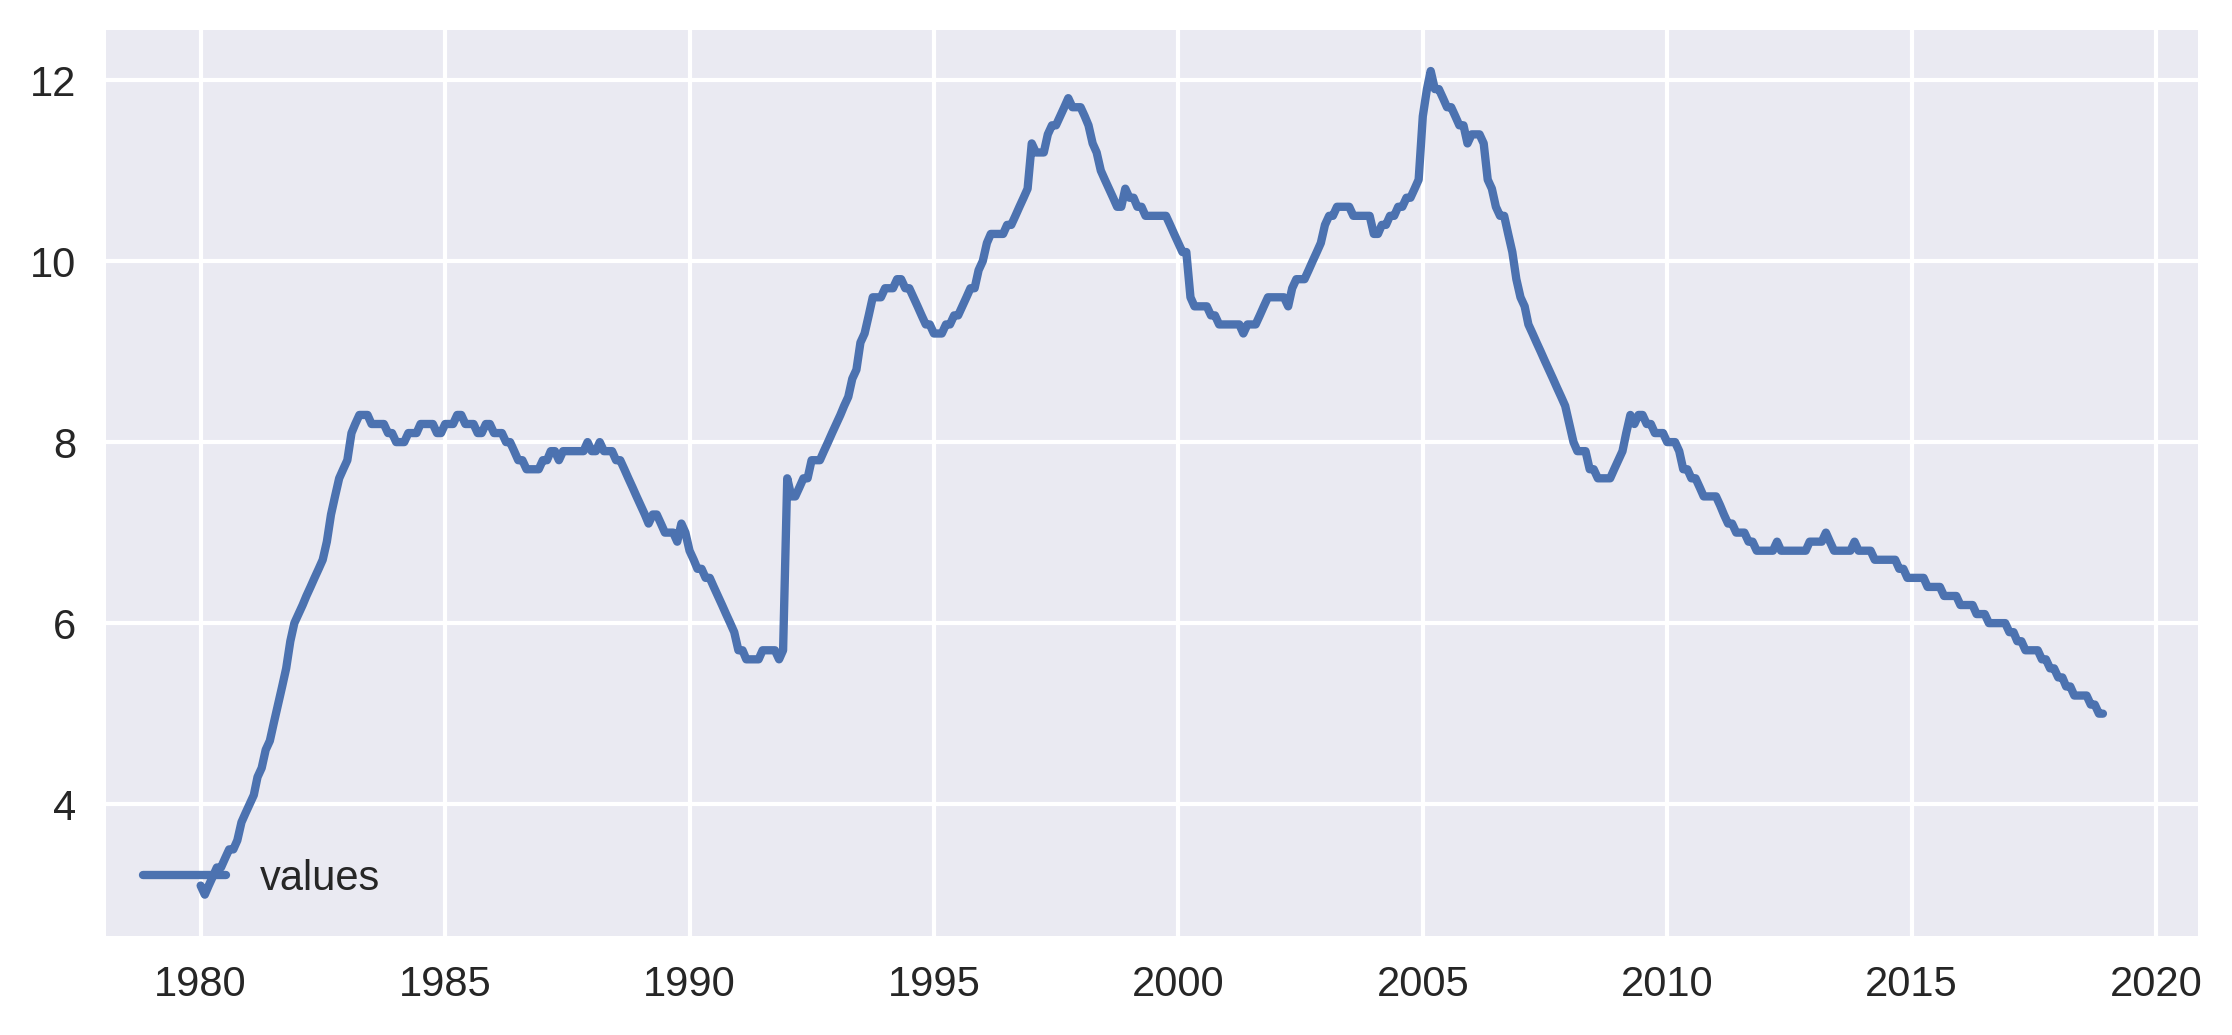

In [11]:
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.plot(inf.index, inf, label=r'values', lw=2)
ax.legend(loc='lower left')
plt.show()

#Basic Sarima Model with p=1 & q=1

In [83]:
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                           Statespace Model Results                           
Dep. Variable:                 values   No. Observations:                  468
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 264.867
Date:                Fri, 15 Jan 2021   AIC                           -523.734
Time:                        12:57:06   BIC                           -511.288
Sample:                    01-01-1980   HQIC                          -518.837
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.001   1103.415      0.000       0.998       1.001
ma.L1          0.1843      0.018     10.162      0.000       0.149       0.220
sigma2         0.0186      0.000     87.989      0.0

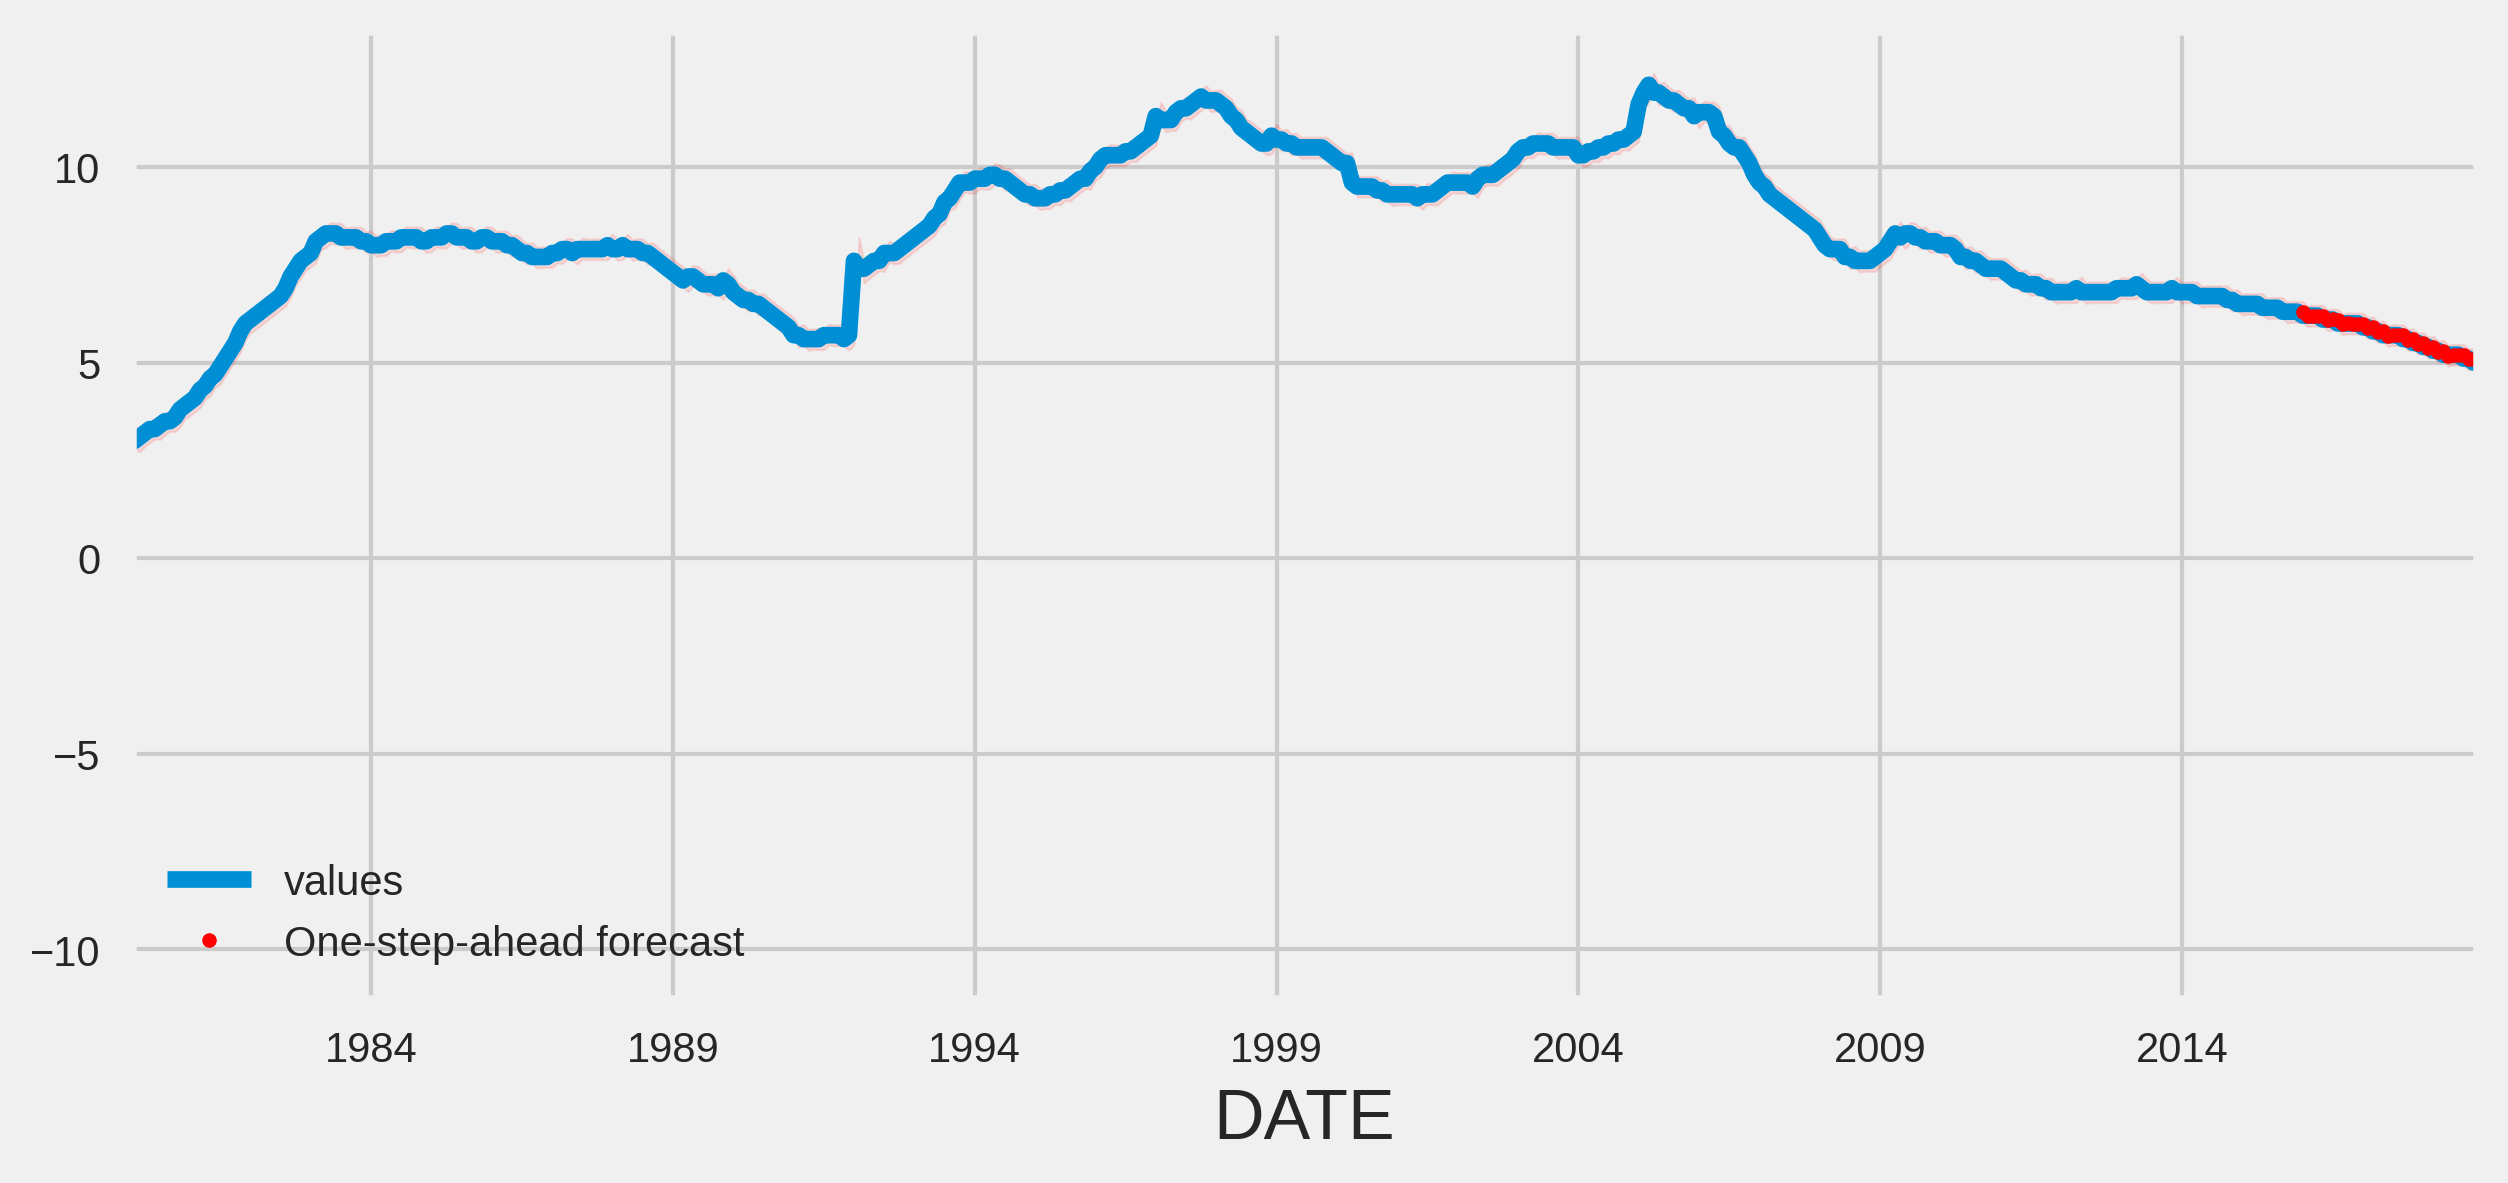

In [84]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci['lower values']
upper = predict_mle_ci['upper values']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)
# Plot data points
inf.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_mle.predicted_mean[training_datalen:len(ts)].plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_mle_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()


In [88]:
output= predict_mle.predicted_mean

In [89]:
pred= output[training_datalen:len(output)]

In [ ]:
pred

In [90]:
test= ts[training_datalen:len(ts)]

In [91]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,pred)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.0037397989312727372
RMSE: 0.061153895470957016


In [92]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred)
print("MAE:",error)

MAE: 0.044083291655000786


#BAYESIAN Sarima


In [20]:
inf = df
#inf is the series we will use for analysis
print(inf.head())

            values
DATE              
1980-01-01     3.1
1980-02-01     3.0
1980-03-01     3.1
1980-04-01     3.2
1980-05-01     3.3


In [21]:
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [22]:
class Loglike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)

In [23]:
# Set sampling params
ndraws = 6000  # number of draws from the distribution
nburn = 1000  # number of "burn-in points" (which will be discarded)

In [24]:
loglike = Loglike(mod)

In [25]:
with pm.Model():
    # Priors
    arL1 = pm.Uniform('ar.L1', -1, 1)
    maL1 = pm.Uniform('ma.L1', -1, 1)
    sigma2 = pm.InverseGamma('sigma2', 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: loglike(v), observed={'v': theta})

    # Draw samples
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.L1, ar.L1]
Sampling chain 1, 3 divergences: 100%|██████████| 7000/7000 [03:45<00:00, 31.09it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8801903043822445, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8836895157807327, but should be close to 0.8. Try to increase the number of tuning steps.


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

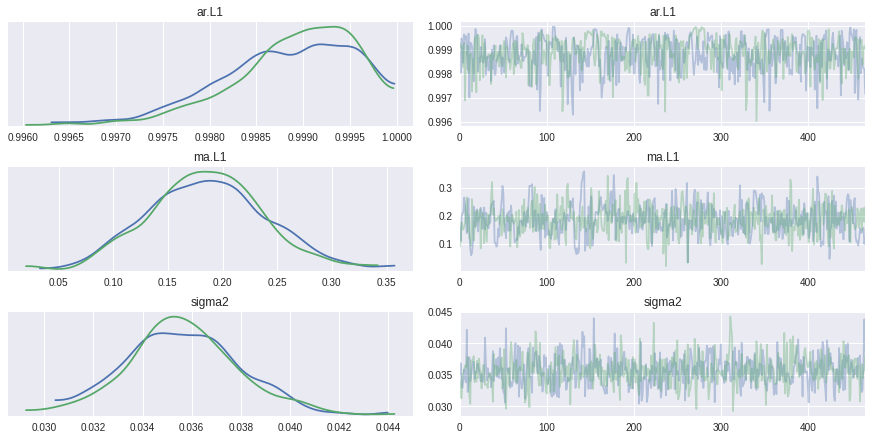

In [26]:
import arviz as az
axes = az.plot_trace(trace[0:len(ts)-1])
fig = axes.ravel()[0].figure

The NUTS sampler is auto-assigned because we provided gradients. PyMC3 will use Metropolis or Slicing samplers if it does not find that gradients are available. There are an impressive number of draws per second for a “block box” style computation! However, note that if the model can be represented directly by PyMC3 (like the AR(p) models mentioned above), then computation can be substantially faster.

Inference is complete, but are the results any good? There are a number of ways to check. The first is to look at the posterior distributions (with lines showing the MLE values):

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08fd5576d8>,
      dtype=object)

<Figure size 576x396 with 0 Axes>

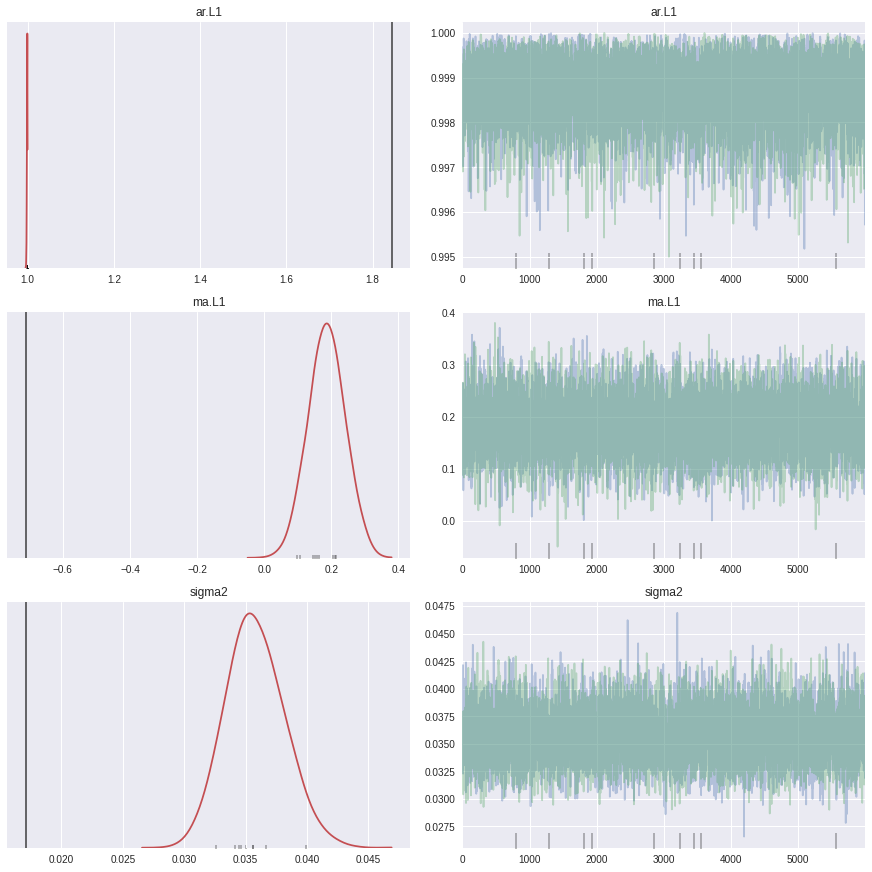

In [27]:
plt.tight_layout()
pm.traceplot(trace,
                 lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
                 combined=True,
                 figsize=(12, 12))

In [28]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ar.L1,0.999,0.001,0.998,1.000,0.000,0.0,6879.0,6876.0,5023.0,3277.0,1.0
ma.L1,0.185,0.054,0.084,0.289,0.001,0.0,7906.0,7535.0,7907.0,7328.0,1.0
sigma2,0.036,0.002,0.031,0.040,0.000,0.0,9335.0,9241.0,9417.0,8314.0,1.0


R^  is the Gelman-Rubin statistic. It tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. for all model parameters, we can have some confidence that convergence has been reached if R-hat<1.2



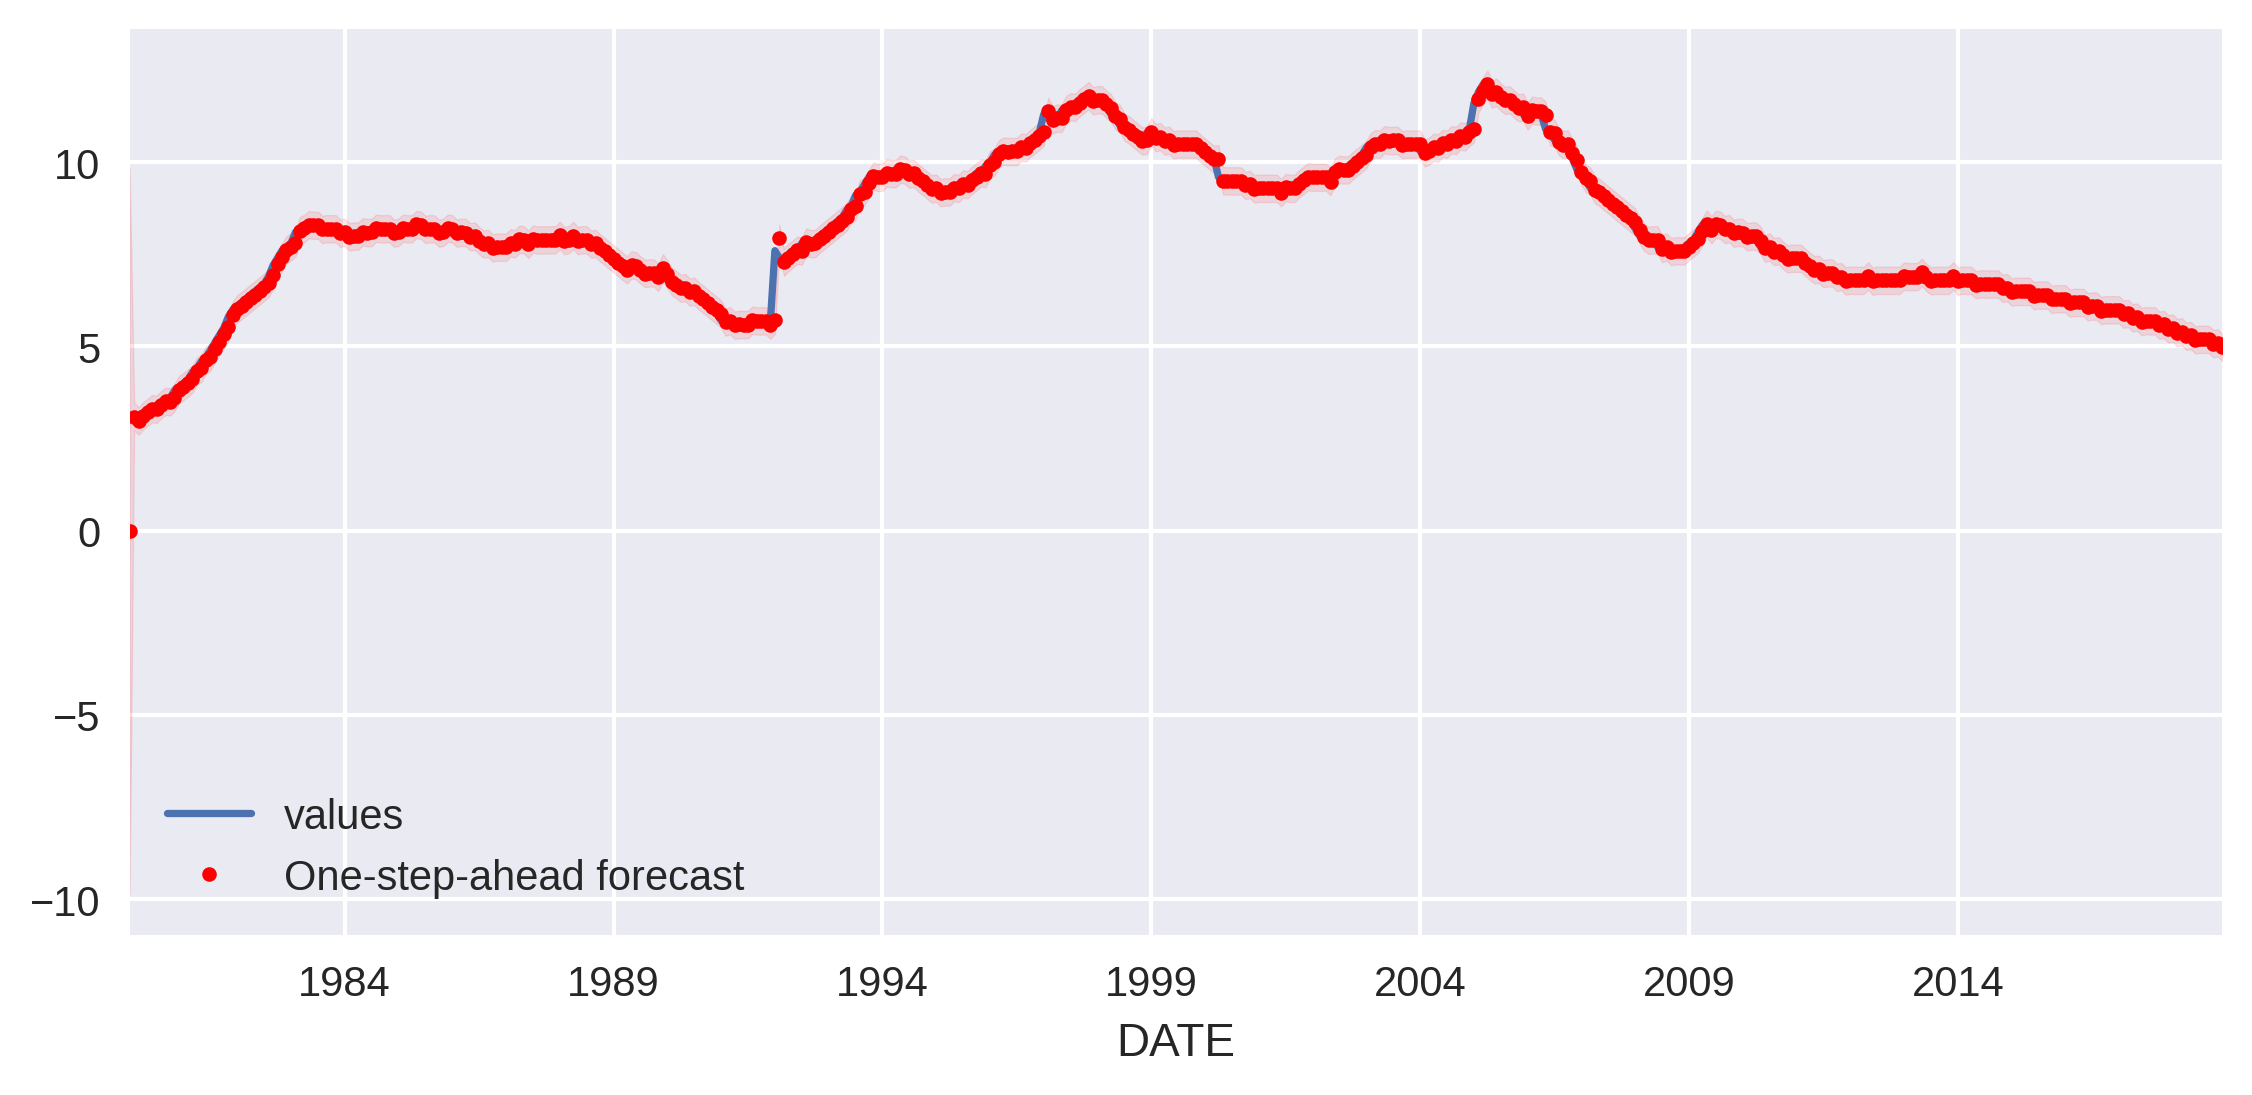

In [29]:
params = pm.summary(trace)['mean'].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci['lower values']
upper = predict_bayes_ci['upper values']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
inf.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_bayes_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()

In [30]:
predict_bayes_output = predict_bayes.predicted_mean

In [31]:
pred_bayes=predict_bayes_output[training_datalen:len(predict_bayes_output)]

#Rmse for bayesian model

In [32]:
from sklearn.metrics import mean_squared_error
error2=mean_squared_error(test,pred_bayes)
print("MSE:",error2)

print("RMSE:",np.sqrt(error2))

MSE: 0.003607692054437129
RMSE: 0.060064066249606585


#Lstm

In [33]:
import keras
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler,StandardScaler
plt.style.use('fivethirtyeight')
import tensorflow as tf

In [34]:
data=df.filter(['values'])
dataset=data.values
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [35]:
train_data= scaled_data[0:training_datalen,:]
time_step=30
test_data= scaled_data[training_datalen-time_step:,:]

In [36]:
training_datalen=len(df)-36

x_train=[]
y_train=[]
for i in range(time_step,len(train_data)):
  x_train.append(train_data[i-time_step:i,0])
  y_train.append(train_data[i,0])
  if i<=time_step:
    print(x_train)
    print(y_train)
    print()

[array([0.01098901, 0.        , 0.01098901, 0.02197802, 0.03296703,
       0.03296703, 0.04395604, 0.05494505, 0.05494505, 0.06593407,
       0.08791209, 0.0989011 , 0.10989011, 0.12087912, 0.14285714,
       0.15384615, 0.17582418, 0.18681319, 0.20879121, 0.23076923,
       0.25274725, 0.27472527, 0.30769231, 0.32967033, 0.34065934,
       0.35164835, 0.36263736, 0.37362637, 0.38461538, 0.3956044 ])]
[0.40659340659340665]



In [37]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [38]:
x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [39]:
print(x_train.shape)

(402, 30, 1)


In [40]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [41]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [65]:
model.fit(x_train,y_train,batch_size=10,epochs=100)

Epoch 1/50
41/41 [==============================] - 1s 23ms/step - loss: 3.7280e-04
Epoch 2/50
41/41 [==============================] - 1s 25ms/step - loss: 5.5839e-04
Epoch 3/50
41/41 [==============================] - 1s 24ms/step - loss: 4.1831e-04
Epoch 4/50
41/41 [==============================] - 1s 25ms/step - loss: 4.0230e-04
Epoch 5/50
41/41 [==============================] - 1s 24ms/step - loss: 4.7320e-04
Epoch 6/50
41/41 [==============================] - 1s 25ms/step - loss: 3.2986e-04
Epoch 7/50
41/41 [==============================] - 1s 25ms/step - loss: 4.3168e-04
Epoch 8/50
41/41 [==============================] - 1s 24ms/step - loss: 3.6438e-04
Epoch 9/50
41/41 [==============================] - 1s 24ms/step - loss: 3.1825e-04
Epoch 10/50
41/41 [==============================] - 1s 25ms/step - loss: 3.1803e-04
Epoch 11/50
41/41 [==============================] - 1s 24ms/step - loss: 4.1967e-04
Epoch 12/50
41/41 [==============================] - 1s 24ms/step - loss: 

In [66]:
x_test=[]
y_test= dataset[training_datalen:,:]
for i in range(time_step,len(test_data)):
  x_test.append(test_data[i-time_step:i,0])

In [67]:
x_test=np.array(x_test)

In [68]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [69]:
pred= model.predict(x_test)
pred1=scaler.inverse_transform(pred)

In [70]:
train= data[:training_datalen]
valid=data[training_datalen:]
valid['pred1']=pred1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


No handles with labels found to put in legend.


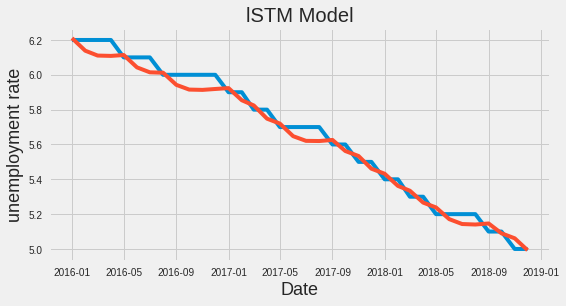

In [71]:
plt.figure(figsize=(8,4))
plt.title("lSTM Model")
plt.xlabel("Date",fontsize=18)
plt.ylabel("unemployment rate",fontsize=18)
plt.plot(valid[['values','pred1']])
plt.legend()
plt.show()

Rmse for LSTM
(can give different results when you run the model multiple times)


In [72]:
from sklearn.metrics import mean_squared_error
error3=mean_squared_error(test,pred1)
print("MSE:",error3)

print("RMSE:",np.sqrt(error3))

MSE: 0.0028417748664929226
RMSE: 0.0533083001651049


In [73]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred1)
print("MAE:",error)

MAE: 0.046992323133680576


for Bayesian Sarima

In [74]:
from sklearn.metrics import mean_squared_error
error2=mean_squared_error(test,pred_bayes)
print("MSE:",error2)

print("RMSE:",np.sqrt(error2))

MSE: 0.003607692054437129
RMSE: 0.060064066249606585


In [75]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred_bayes)
print("MAE:",error)

MAE: 0.04450709714512022


#Hybridization(Bayesian Sarima +Lstm)

In [76]:
NEW_PREDICTION= (pred1.T+pred_bayes.values)/2

In [77]:
NEW_PREDICTION= np.array(NEW_PREDICTION)

In [78]:
NEW_PREDICTION

array([[6.25272248, 6.15737913, 6.15435501, 6.15135376, 6.1542248 ,
        6.05948751, 6.05629625, 6.05305277, 5.95940892, 5.95675218,
        5.95384984, 5.95683703, 5.9592999 , 5.86527564, 5.86127333,
        5.76206304, 5.75929139, 5.66184286, 5.6597698 , 5.65714816,
        5.66064571, 5.5696466 , 5.56617731, 5.46859896, 5.46537675,
        5.3691989 , 5.36664783, 5.27129929, 5.26875556, 5.1738678 ,
        5.17119438, 5.16767978, 5.1710548 , 5.08358929, 5.08016625,
        4.98480519]])

In [79]:
pred_bayes.values

array([6.29480072, 6.17626187, 6.19819155, 6.19413456, 6.19488511,
       6.07634626, 6.09827594, 6.09421895, 5.97656949, 5.99833464,
       5.99430809, 5.995053  , 5.99491519, 5.87654069, 5.89843997,
       5.77598861, 5.79864211, 5.67605121, 5.69873053, 5.69453485,
       5.69531105, 5.57676746, 5.59869802, 5.47624087, 5.49889544,
       5.37630434, 5.3989837 , 5.27638802, 5.29906822, 5.17647238,
       5.19915261, 5.19495677, 5.195733  , 5.0771894 , 5.09911996,
       4.97666281])

In [80]:
test.shape

(36, 1)

In [58]:
NEW_PREDICTION.shape

(1, 36)

In [59]:
pred1.shape

(36, 1)

In [81]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,NEW_PREDICTION.T)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.0023310739582783143
RMSE: 0.04828119673618617


In [82]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,NEW_PREDICTION.T)
print("MAE:",error)

MAE: 0.04574971013940036


#Sarima+LSTM

In [ ]:
pred1

In [ ]:
pred

In [93]:
NEW_PREDICTION2= (pred1.T+pred.values)/2

In [94]:
NEW_PREDICTION2

array([[6.25409871, 6.15876705, 6.15569749, 6.15271263, 6.15557917,
        6.06085357, 6.05761688, 6.05438978, 5.96075202, 5.9580512 ,
        5.95516493, 5.95814769, 5.96061165, 5.86659773, 5.8625503 ,
        5.76336691, 5.76054559, 5.66312508, 5.6610021 , 5.65839794,
        5.66189074, 5.57090338, 5.56738864, 5.46983726, 5.46656538,
        5.37041554, 5.36781455, 5.27249408, 5.26990042, 5.17504073,
        5.17231739, 5.16882026, 5.17219053, 5.08473677, 5.08126829,
        4.9859342 ]])

In [96]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,NEW_PREDICTION2.T)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.0023296871576256434
RMSE: 0.04826683289408622


In [97]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,NEW_PREDICTION2.T)
print("MAE:",error)

MAE: 0.04539002498651211
